# Experiments results analysis

As it is stated in the paper, we have to answer the following questions:
Q1. How much metrics (RMSE and NDCG@10) differ between strategies?
Q2. How much evaluation times differ between strategies?
Q3. Do metric values depend on the strategy choice?
Q4. Does the proper choice of the strategy depend on the version of the dataset (i.e., on the dataset size)?

Imports and constants:

In [1]:
import os
from typing import Optional, Any, Callable
from itertools import chain

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from drsu.datasets import *
from functools import reduce
from scipy import stats

pd.options.mode.chained_assignment = None

RESULTS_DIR = '../results'
STRATEGIES = ['Random (ts = 0.20)', 'CV (n = 5)', 'Time (ts = 0.20)', 'Time-U (ts = 0.20)']

DATASET_GROUPS = {
    'All': [dd for dd in ALL_DESCRIPTORS if not (dd.id.startswith('amz_') and dd.n_rows >= 1500000)],
    'Movies': [MOVIELENS_100K, MOVIELENS_1M, MOVIELENS_10M],
    'Books': [LIBRARY_THING, GOODREADS_REVIEW_SPOILERS],
    'Drug': [DRUG_RECOMMENDATIONS],
    'Customer': [dd for dd in ALL_DESCRIPTORS if dd.id.startswith('amz_') and dd.n_rows < 1500000] + [EPINIONS],
}

Utility functions definitions:

In [2]:
def read_results_file(filename: str) -> pd.DataFrame:
    """Reads file from RESULTS_DIR as pandas DataFrame"""
    res = pd.read_csv(os.path.join(RESULTS_DIR, filename), header=[0, 1])
    res.set_index(res.columns[0], inplace=True)
    res.columns = pd.MultiIndex.from_tuples(res.columns)
    return res


def get_dataset_descriptor_by_id(id: str) -> Optional[DatasetDescriptor]:
    """Maps string dataset ids to instances of DatasetDescriptor"""
    for dd in ALL_DESCRIPTORS:
        if dd.id == id:
            return dd
    return None


def extract_metric_df(results_df: pd.DataFrame, metric: str) -> pd.DataFrame:
    """
    Takes the results DataFrame with multi-index columns (strategy, metric) and extracts columns for the given metric.
    :param results_df: results DataFrame with multiple metrics
    :param metric: rmse, time, or ndcg
    :return: DataFrame containing only given metric values, with simple one-level columns (corresponding to strategies)
    """
    result: pd.DataFrame = results_df.copy()
    result = result.loc[:, (slice(None), metric)]
    result.columns = result.columns.droplevel(level=1)
    result.index.name = None
    return result

At first, let's read all the results with respect to groups.
Since the results must be comparable between different datasets, we normalize them.
RMSE values are divided by rating scale length (thus giving an nRMSE).
Time values are divided by the minimal times given for this dataset version, model, and metric.

In [3]:
def read_normalized_results_by_group() -> dict[str, list[dict[str, pd.DataFrame]]]:
    """
    Reads normalized results (nRMSE, NDCG@10, and relative evaluation times) for all the experiments.
    :return: {dataset group name -> List of {model_metric -> df with normalized metric values and relative evaluation times}}
    """
    def normalize_rmse(df: pd.DataFrame, dd: DatasetDescriptor) -> pd.DataFrame:
        result: pd.DataFrame = df.copy()
        result.loc[:, (slice(None), 'rmse')] = result.loc[:, (slice(None), 'rmse')].applymap(
            lambda x: x / (dd.rating_scale[1] - dd.rating_scale[0]))

        return result

    def normalize_time(df: pd.DataFrame) -> pd.DataFrame:
        result: pd.DataFrame = df.copy()

        times = result.loc[:, (slice(None), 'time')]
        relative_times = (times.T / times.min(axis=1)).T
        result.loc[:, (slice(None), 'time')] = relative_times

        return result

    normalized_results_by_group = dict()
    for group_name, dds in DATASET_GROUPS.items():
        current_group_results = []
        for dd in dds:
            results = {
                'svd_rmse': read_results_file(f'{dd.id}_svd_rmse_261021_1.csv'),
                'svd_ndcg': read_results_file(f'{dd.id}_svd_ndcg_271021_1.csv'),
                'svdpp_rmse': read_results_file(f'{dd.id}_svdpp_rmse_261021_1.csv'),
                'svdpp_ndcg': read_results_file(f'{dd.id}_svdpp_ndcg_271021_1.csv')
            }

            for model_metric, df in results.items():
                df = normalize_time(df)
                if model_metric.endswith('_rmse'):
                    df = normalize_rmse(df, dd)

                results[model_metric] = df

            current_group_results.append(results)

        normalized_results_by_group[group_name] = current_group_results

    return normalized_results_by_group


normalized_results_by_group: dict[str, list[dict[str, pd.DataFrame]]] = read_normalized_results_by_group()
normalized_results_by_group['Movies'][0]['svd_rmse']

Random (ts = 0.20)           CV (n = 5)            \
                                 rmse      time       rmse      time   
(strategy, metric)                                                     
0                            0.312617  1.498344   0.312436  5.293382   
1                            0.271212  1.000000   0.271326  4.317166   
2                            0.286093  1.029428   0.285949  4.636298   
3                            0.268509  1.121129   0.268677  5.010340   
4                            0.273791  1.109488   0.274074  4.382503   

                   Time (ts = 0.20)           Time-U (ts = 0.20)            
                               rmse      time               rmse      time  
(strategy, metric)                                                          
0                          0.312691  1.000000           0.312625  1.207630  
1                          0.271659  1.079857           0.271431  1.099503  
2                          0.286043  1.000000           0.286181  1.071883  
3                          0.268592  1.047570           0.268651  1.000000  
4                          0.273644  1.202335           0.273977  1.000000

To answer the given questions, we need to aggregate data multiple ways.
For Q1 & Q2, we will analyze values of normalized RMSE, NDCG@10 and time for each strategy, dataset group, model, and metric. For times, both normalized RMSE and NDCG@10 times are taken.
For Q3, we will analyze the dependency between normalized RMSE and NDCG@10 values and used strategies, for each dataset group and model. Only values for the largest dataset version are taken (to make members of population independent for a statistical test).
For Q4, we will analyze the dependency between the number of times a strategy has been the best and the version of a dataset, for each dataset group, model, and strategy.

So, we need two aggregations:
1. By dataset group, model, metric, strategy and dataset version.
2. By dataset group, model, metric, and strategy.

Because these aggregations will be used multiple times, we cache them.
Let's make a helper function that caches the results of aggregation by dataset group, model and metric:

In [4]:
def cache_agg_results(aggregator: Callable[[str, str, str], pd.DataFrame]) -> dict[str, dict[str, pd.DataFrame]]:
    """
    Runs aggregator function for all dataset groups, models, and metrics.
    Aggregator function must take a group name, model name, and metric, and return a DataFrame with aggregated values.
    :param aggregator: Aggregator function
    :return: A dictionary that maps group name to DataFrames with results aggregated by model and metric
    """
    result = dict()
    for group_name, dds in DATASET_GROUPS.items():
        result[group_name] = {
            'svd_rmse': aggregator(group_name, 'svd', 'rmse'),
            'svd_ndcg': aggregator(group_name, 'svd', 'ndcg'),
            'svd_time': aggregator(group_name, 'svd', 'time'),
            'svdpp_rmse': aggregator(group_name, 'svdpp', 'rmse'),
            'svdpp_ndcg': aggregator(group_name, 'svdpp', 'ndcg'),
            'svdpp_time': aggregator(group_name, 'svdpp', 'time'),
        }

    return result

Aggregate the normalized results by dataset group, model, metric, strategy and dataset version:

In [5]:
def get_normalized_results_agg_by_strategy_and_version(group_name: str, model: str, metric: str) -> pd.DataFrame:
    """
    Aggregates the normalized results to lists in cells of a DataFrame, grouping them by the strategy and the version of a dataset
    :param group_name: The name of the group (i.e., DATASET_GROUPS key)
    :param model: svd or svdpp
    :param metric: rmse, ndcg, or time
    :return: DataFrame with strategies as columns and rows with lists of normalized results for the given strategy and dataset version.
    """
    normalized_results_group: list[dict[str, pd.DataFrame]] = normalized_results_by_group[group_name]

    metric_df_list: list[pd.DataFrame] = []
    for results in normalized_results_group:
        if metric == 'time':
            metric_df_list.append(extract_metric_df(results[f'{model}_rmse'], metric))
            metric_df_list.append(extract_metric_df(results[f'{model}_ndcg'], metric))
        else:
            metric_df_list.append(extract_metric_df(results[f'{model}_{metric}'], metric))

    # Aggregating list of rel_delta DataFrames to a single DataFrame with lists in cells
    metric_df_list = list(map(lambda df: df.applymap(lambda x: [x]), metric_df_list))
    df_agg_by_strategy_and_version = reduce(lambda left, right: left.combine(right, lambda l, r: l + r), metric_df_list)

    return df_agg_by_strategy_and_version


normalized_results_agg_by_strategy_and_version = cache_agg_results(get_normalized_results_agg_by_strategy_and_version)
normalized_results_agg_by_strategy_and_version['Movies']['svd_rmse']

,Random (ts = 0.20),CV (n = 5),Time (ts = 0.20),Time-U (ts = 0.20)
0,"[0.31261707040120934, 0.2805626951797465, 0.24...","[0.3124361777271092, 0.28058726167961723, 0.24...","[0.31269090478741945, 0.2805061331695981, 0.24...","[0.31262546331851254, 0.28056344028243424, 0.2..."
1,"[0.27121249402588765, 0.2790531549569246, 0.25...","[0.27132604821951345, 0.2789600286811091, 0.25...","[0.2716587069013204, 0.2794727496571077, 0.256...","[0.2714314594130592, 0.27918872043203685, 0.25..."
2,"[0.2860930684943692, 0.26264447647191186, 0.24...","[0.28594924132060934, 0.262728325468407, 0.243...","[0.2860434482592184, 0.262688344135084, 0.2434...","[0.2861808057411417, 0.26271478079117494, 0.24..."
3,"[0.2685092353775057, 0.2688242059101398, 0.249...","[0.2686774778595933, 0.26887380211636386, 0.24...","[0.2685917529956468, 0.2690553145204021, 0.249...","[0.26865061546606556, 0.2688122288402766, 0.24..."
4,"[0.2737907402385039, 0.2262488634332108, 0.245...","[0.27407358421669215, 0.2274425825279461, 0.24...","[0.2736439771520068, 0.22671193752104984, 0.24...","[0.273977305093299, 0.2259899383638474, 0.2458..."


Aggregate the normalized results by dataset group, model, metric, and strategy:

In [6]:
def get_normalized_results_agg_by_strategy(group_name: str, model: str, metric: str) -> pd.DataFrame:
    """
    Aggregates the normalized results to lists in cells of a DataFrame, grouping them by the strategy.
    :param group_name: group_name: The name of the group (i.e., DATASET_GROUPS key)
    :param model: svd or svdpp
    :param metric: rmse, ndcg, or time
    :return: DataFrame with strategies as columns and a single row with lists of normalized results for the given strategy
    """
    df_agg_by_strategy_and_version = normalized_results_agg_by_strategy_and_version[group_name][f'{model}_{metric}']
    df_agg_by_strategy = df_agg_by_strategy_and_version.T\
        .aggregate(lambda x: list(chain(*x.tolist())), axis=1)\
        .to_frame().T

    return df_agg_by_strategy


normalized_results_agg_by_strategy = cache_agg_results(get_normalized_results_agg_by_strategy)
normalized_results_agg_by_strategy['Movies']['svd_rmse']

,Random (ts = 0.20),CV (n = 5),Time (ts = 0.20),Time-U (ts = 0.20)
0,"[0.31261707040120934, 0.2805626951797465, 0.24...","[0.3124361777271092, 0.28058726167961723, 0.24...","[0.31269090478741945, 0.2805061331695981, 0.24...","[0.31262546331851254, 0.28056344028243424, 0.2..."


## Q1 & Q2. How much metric values and evaluation times differ between strategies?

After the calculations above, we have `normalized_results_agg_by_strategy` dictionary: dataset group name -> model + metric -> DataFrame containing normalized results for each strategy.
To examine the distributions of errors and times, we visualize them as violin plots.

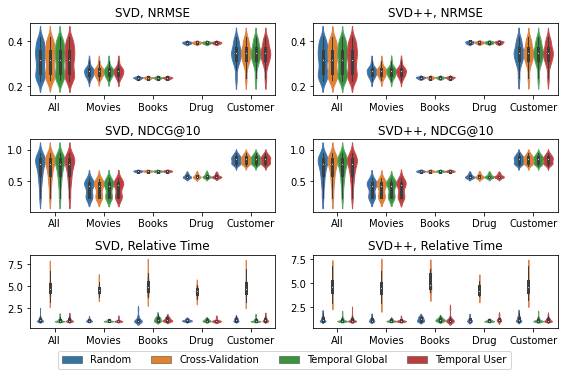

In [7]:
def make_metrics_violinplot(ax) -> None:
    """Draws violin plots for metrics, grouping them by strategy, separating by a dataset group; models and
    metrics are on different axes
    """

    def patch_violinplot(palette, n, ax):
        """Removes borders from violins. See https://stackoverflow.com/questions/57270478/how-to-change-border-color-of-violin-plot-in-pandas-graph"""
        from matplotlib.collections import PolyCollection
        violins = [art for art in ax.get_children() if isinstance(art, PolyCollection)]
        colors = sns.color_palette(palette, n_colors=n) * (len(violins) // n)
        for i in range(len(violins)):
            violins[i].set_edgecolor(colors[i])

    ax_iter = iter(ax.flatten())
    for metric in ['rmse', 'ndcg', 'time']:
        for model in ['svd', 'svdpp']:
            data = []
            for group_name in DATASET_GROUPS.keys():
                normalized_results_agg_by_strategy_for_current_group = normalized_results_agg_by_strategy[group_name]
                model_metric = f'{model}_{metric}'
                df = normalized_results_agg_by_strategy_for_current_group[model_metric]

                for strategy_name in STRATEGIES:
                    for metric_value in df.loc[0, strategy_name]:
                        data.append({
                            'Dataset Group': group_name,
                            'Strategy': {
                                'Random (ts = 0.20)': 'Random',
                                'CV (n = 5)': 'Cross-Validation',
                                'Time (ts = 0.20)': 'Temporal Global',
                                'Time-U (ts = 0.20)': 'Temporal User'
                            }[strategy_name],
                            'Metric Value': metric_value
                        })

            cur_ax = next(ax_iter)

            sns_data = pd.DataFrame(data, columns=['Dataset Group', 'Strategy', 'Metric Value'])
            sns.violinplot(
                data=sns_data,
                x='Dataset Group', y='Metric Value', hue='Strategy',
                ax=cur_ax, linewidth=1
            )
            patch_violinplot("deep", 4, cur_ax)

            cur_ax.legend([], [], frameon=False)
            cur_ax.set_xlabel(None)
            cur_ax.set_ylabel(None)

            model_name = {'svd': 'SVD', 'svdpp': 'SVD++'}[model]
            metric_name = {'rmse': 'NRMSE', 'ndcg': 'NDCG@10', 'time': 'Relative Time'}[metric]
            cur_ax.set_title(f'{model_name}, {metric_name}')


fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(8, 5))
make_metrics_violinplot(ax)
handles, labels = ax[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.05))
fig.tight_layout()
plt.savefig('../plots/Metric Values Violin Plot.pdf', bbox_inches='tight')

## Q3. Do metric values depend on the strategy choice?

Here we need to analyze the dependency of two variables.
The independent one is strategy (i.e., a categorical one).
The dependent one is normalized metric values given for this strategy (i.e., a continuous one).
To test if NRMSE or NDCG@10 values significantly differ between different strategies, we can use either ANOVA or Kruskal Wallis H-test.
To decide which test is suitable, we need to take a look on the distribution of these metrics.
The violin plots from Q1 show they are probably not normal, but here we are mostly interested in distributions for the largest dataset versions.
Also, the results should be regrouped to assure there are enough points to perform a statistical test.
We will group them as follows: All datasets, All except Customers, and Customers.

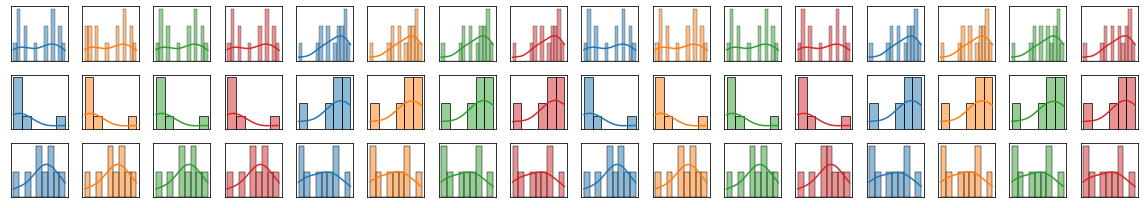

In [8]:
def plot_metric_distributions_by_strategy(ax: Any) -> None:
    inner_dataset_groups: dict[str, set[str]] = {
        'All': {'All'},
        'Non-Customer': {'Movies', 'Books', 'Drug'},
        'Customer': {'Customer'}
    }

    # inner group name -> model + metric -> strategy -> results
    v4_results_for_inner_groups: dict[str, dict[str, dict[str, list[float]]]] = dict()
    for inner_group_name in inner_dataset_groups.keys():
        model_metric_results = dict()
        for model_metric in ['svd_rmse', 'svd_ndcg', 'svdpp_rmse', 'svdpp_ndcg']:
            strategy_results = dict()
            for strategy_name in STRATEGIES:
                strategy_results[strategy_name] = []
            model_metric_results[model_metric] = strategy_results
        v4_results_for_inner_groups[inner_group_name] = model_metric_results

    for inner_group_name in inner_dataset_groups.keys():
        for group_name in inner_dataset_groups[inner_group_name]:
            normalized_results_agg_by_strategy_and_version_for_current_group = normalized_results_agg_by_strategy_and_version[group_name]
            for model_metric in filter(lambda mm: not '_time' in mm, normalized_results_agg_by_strategy_and_version_for_current_group.keys()):
                metric_lists_df = normalized_results_agg_by_strategy_and_version_for_current_group[model_metric]

                for strategy_name in STRATEGIES:
                    results_for_strategy = metric_lists_df.loc[4, strategy_name]
                    v4_results_for_inner_groups[inner_group_name][model_metric][strategy_name] = v4_results_for_inner_groups[inner_group_name][model_metric][strategy_name] + results_for_strategy

    ax = iter(ax.flatten())
    for results_for_inner_group in v4_results_for_inner_groups.values():
        for results_for_model_metric in results_for_inner_group.values():
            colors = iter([f'C{i}' for i in range(len(STRATEGIES))])
            for results_for_strategy in results_for_model_metric.values():
                cur_ax = next(ax)

                sns.histplot(results_for_strategy, ax=cur_ax, bins=len(results_for_strategy), kde=True, color=next(colors), legend=False)
                cur_ax.xaxis.set_visible(False)
                cur_ax.yaxis.set_visible(False)


fig, ax = plt.subplots(nrows=3, ncols=16, figsize=(16, 3))
plot_metric_distributions_by_strategy(ax)
fig.tight_layout()

As the plots show, examined values are not always normally distributed and characterized by their median rather than by the mean.
So, we need the non-parametric Kruskal-Wallis H-test.
The null hypothesis is that measured metrics' medians do not differ between strategies (i.e., there is no significant difference which strategy is used).

In [9]:
def calc_kruskal_of_metrics_by_strategy() -> pd.DataFrame:
    """
    Calculates Kruskal-Wallis H-test values for metric values.
    Results are split by model, metric, and dataset group.
    Within each split, measurements given for different strategies are tested.
    :return: DataFrame with dataset groups as rows, models + metrics as columns. Each column contains two values - test result and p-value.
    """
    inner_dataset_groups: dict[str, set[str]] = {
        'All': {'All'},
        'Non-Customer': {'Movies', 'Books', 'Drug'},
        'Customer': {'Customer'}
    }

    result: pd.DataFrame = pd.DataFrame(
        index=inner_dataset_groups.keys(),
        columns=pd.MultiIndex.from_product([['svd_rmse', 'svd_ndcg', 'svdpp_rmse', 'svdpp_ndcg'], ['KW', 'p']])
    )

    # Inner group name -> Model + Metric -> Strategy -> Population (rel. delta values)
    populations_by_inner_group: dict[str, dict[str, dict[str, list[float]]]] = dict()

    for inner_group_name, group_names_set in inner_dataset_groups.items():
        populations_by_model_metric: dict[str, dict[str, list[float]]] = dict()
        for model_metric in ['svd_rmse', 'svd_ndcg', 'svdpp_rmse', 'svdpp_ndcg']:
            populations_by_model_metric[model_metric] = dict()
            for strategy_name in STRATEGIES:
                populations_by_model_metric[model_metric][strategy_name] = []

        for group_name in group_names_set:
            metric_lists_df_dict = normalized_results_agg_by_strategy_and_version[group_name]
            for model_metric in filter(lambda mm: not '_time' in mm, metric_lists_df_dict.keys()):
                metric_values_by_strategy = metric_lists_df_dict[model_metric]
                for strategy_name in STRATEGIES:
                    cur_population = metric_values_by_strategy.loc[4, strategy_name]
                    populations_by_model_metric[model_metric][strategy_name] = populations_by_model_metric[model_metric][strategy_name] + cur_population

        populations_by_inner_group[inner_group_name] = populations_by_model_metric

    for inner_group_name in populations_by_inner_group.keys():
        for model_metric, populations_by_strategy in populations_by_inner_group[inner_group_name].items():
            populations = list(populations_by_strategy.values())

            test_result, p_value = stats.kruskal(*populations)
            result.loc[inner_group_name, (model_metric, 'KW')] = test_result
            result.loc[inner_group_name, (model_metric, 'p')] = p_value

    return result


calc_kruskal_of_metrics_by_strategy().loc[:, (slice(None), 'p')]

,svd_rmse,svd_ndcg,svdpp_rmse,svdpp_ndcg
,p,p,p,p
All,0.998604,0.999234,0.997511,0.99443
Non-Customer,0.995512,0.976506,0.999856,0.980752
Customer,0.983305,0.999195,0.976745,0.975759


As the results show, p-values are very close to 1, so we surely accept the null hypothesis that there is no significant difference between errors given for different splitting strategies.

## Q4. Does the proper choice of the strategy depend on the version of the dataset (i.e., on the dataset size)?

Here we need to count how many times a strategy was preferable over others in experiments with the same dataset version.
Next, these numbers are aggregated and one analyzes if there is any dependency between the version (size) and the number of times a strategy has been the best.
To do so, Chi-Square test is applied.

In [10]:
def calc_chisquare_for_choices_over_versions() -> tuple[pd.DataFrame, dict[str, dict[str, dict[str, list[int]]]]]:
    """
    Calculates Kruskal-Wallis H-test values for metrics.
    Results are split by model, metric, dataset group, and strategy.
    Within each split, deltas given for different dataset version are tested.
    :return: A tuple containing:
        - DataFrame with dataset groups + strategies as rows, models + metrics as columns. Each column contains two values - test result and p-value
        - Dict: Inner group name -> Model + Metric -> Strategy -> Population (best hits over dataset versions)
    """
    inner_dataset_groups: dict[str, set[str]] = {
        'All': {'All'},
        'Non-Customer': {'Movies', 'Books', 'Drug'},
        'Customer': {'Customer'}
    }

    result: pd.DataFrame = pd.DataFrame(
        index=pd.MultiIndex.from_product([inner_dataset_groups.keys(), STRATEGIES]),
        columns=pd.MultiIndex.from_product([['svd_rmse', 'svd_ndcg', 'svdpp_rmse', 'svdpp_ndcg'], ['CS', 'p']])
    )

    # Inner group name -> Model + Metric -> Strategy -> Population (best hits over dataset versions)
    populations_by_inner_group: dict[str, dict[str, dict[str, list[int]]]] = dict()

    for inner_group_name, group_names_set in inner_dataset_groups.items():
        populations_by_model_metric_by_strategy: dict[str, dict[str, list[int]]] = dict()
        for model_metric in ['svd_rmse', 'svd_ndcg', 'svdpp_rmse', 'svdpp_ndcg']:
            populations_by_model_metric_by_strategy[model_metric] = dict()
            for strategy_name in STRATEGIES:
                populations_by_model_metric_by_strategy[model_metric][strategy_name] = [0 for _ in range(5)]

        for group_name in group_names_set:
            metric_lists_df_dict = normalized_results_agg_by_strategy_and_version[group_name]
            for model_metric in filter(lambda mm: not '_time' in mm, metric_lists_df_dict.keys()):
                metric_values_by_strategy = metric_lists_df_dict[model_metric]
                for version_n in range(5):
                    current_version_results = metric_values_by_strategy.loc[version_n]
                    current_version_results_arr = np.array(list(current_version_results))
                    if model_metric.endswith('_rmse'):
                        hits = 1 * (current_version_results_arr == np.min(current_version_results_arr, axis=0))
                    else:
                        hits = 1 * (current_version_results_arr == np.max(current_version_results_arr, axis=0))

                    for strategy_idx in range(len(STRATEGIES)):
                        strategy_name = STRATEGIES[strategy_idx]
                        populations_by_model_metric_by_strategy[model_metric][strategy_name][version_n] = populations_by_model_metric_by_strategy[model_metric][strategy_name][version_n] + np.sum(hits[strategy_idx, :])

        populations_by_inner_group[inner_group_name] = populations_by_model_metric_by_strategy

    for inner_group_name in populations_by_inner_group.keys():
        for model_metric, populations_by_strategy in populations_by_inner_group[inner_group_name].items():
            for strategy_name in STRATEGIES:
                population = populations_by_strategy[strategy_name]

                test_result, p_value = stats.chisquare(population)
                result.loc[(inner_group_name, strategy_name), (model_metric, 'CS')] = test_result
                result.loc[(inner_group_name, strategy_name), (model_metric, 'p')] = p_value

    return result, populations_by_inner_group


q4_chi_square, q4_hits = calc_chisquare_for_choices_over_versions()
q4_chi_square.loc[:, (slice(None), 'p')]

svd_rmse  svd_ndcg svdpp_rmse svdpp_ndcg
                                        p         p          p          p
All          Random (ts = 0.20)  0.218613  0.135888   0.542729   0.066298
             CV (n = 5)          0.951864  0.608186   0.719043   0.788121
             Time (ts = 0.20)    0.498165  0.584587   0.689886   0.597156
             Time-U (ts = 0.20)  0.808792  0.774408   0.926149   0.147832
Non-Customer Random (ts = 0.20)  0.446052  0.516893   0.735759   0.342547
             CV (n = 5)          0.945023  0.199148   0.735759   0.735759
             Time (ts = 0.20)    0.446052  0.516893   0.406006   0.683371
             Time-U (ts = 0.20)  0.735759  0.091578   0.930627   0.705136
Customer     Random (ts = 0.20)  0.406006  0.175599   0.406006   0.044583
             CV (n = 5)          0.855695  0.472054   0.334162   0.702359
             Time (ts = 0.20)    0.557825  0.865985   0.352012   0.030577
             Time-U (ts = 0.20)   0.91858  0.816757   0.985344   0.213144

In almost all cases, there are no evidence that a strategy is clearly preferable for smaller or larger versions of a dataset.
The exceptions are Temporal results for SVD++ NDCG@10 at Customer group (p-value = 0.03) and Temporal-User results for SVD NDCG@10 result at Non-Customer group (p-value = 0.09).
Let's examine for which version they are preferable:

In [11]:
q4_hits['Customer']['svdpp_ndcg']['Time (ts = 0.20)']

[2, 0, 0, 4, 0]

In [12]:
q4_hits['Non-Customer']['svd_ndcg']['Time-U (ts = 0.20)']

[1, 1, 0, 5, 3]

In [13]:
q4_hits['Customer']['svdpp_ndcg']['Random (ts = 0.20)']

[4, 1, 5, 0, 7]

In [14]:
q4_hits['All']['svdpp_ndcg']['Random (ts = 0.20)']

[8, 2, 6, 1, 8]

This might give a small advantage to Temporal strategies for larger dataset versions, but this is not enough to make a confident conclusion that they are preferable.